<a href="https://colab.research.google.com/github/RickyBandi/EXPLAINABLE-AI/blob/main/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Setup & Google Drive Mount**

In [ ]:
# Install dependencies (uncomment if needed)
# !pip install imbalanced-learn xgboost shap lime pdpbox

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

# Load dataset (Update the path to your file inside Drive)
DATA_PATH = "/content/drive/MyDrive/BTECH/3rd Year/5th Sem/Dataset/lung_cancer_dataset.csv"
df = pd.read_csv(DATA_PATH)
print("Dataset loaded:", df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded: (50000, 11)


**2. Exploratory Data Analysis (EDA)**

   age  gender  pack_years radon_exposure  asbestos_exposure  \
0   69    Male   66.025244           High                  0   
1   32  Female   12.780800           High                  0   
2   89  Female    0.408278         Medium                  1   
3   78  Female   44.065232            Low                  0   
4   38  Female   44.432440         Medium                  1   

   secondhand_smoke_exposure  copd_diagnosis alcohol_consumption  \
0                          0               1            Moderate   
1                          1               1            Moderate   
2                          1               1                 NaN   
3                          1               0            Moderate   
4                          0               1                 NaN   

   family_history  lung_cancer  
0               0            0  
1               1            1  
2               0            1  
3               0            1  
4               1            1  

Missing

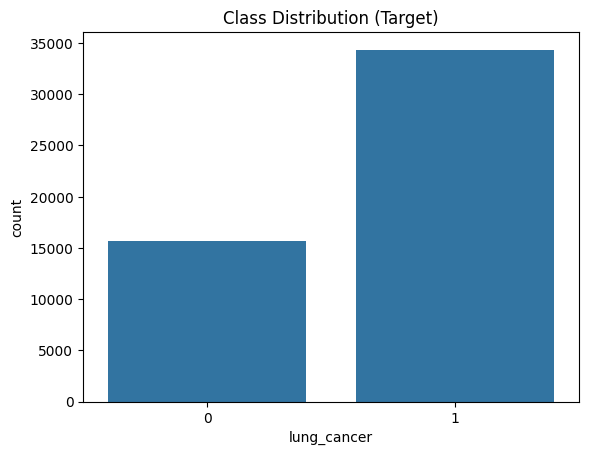

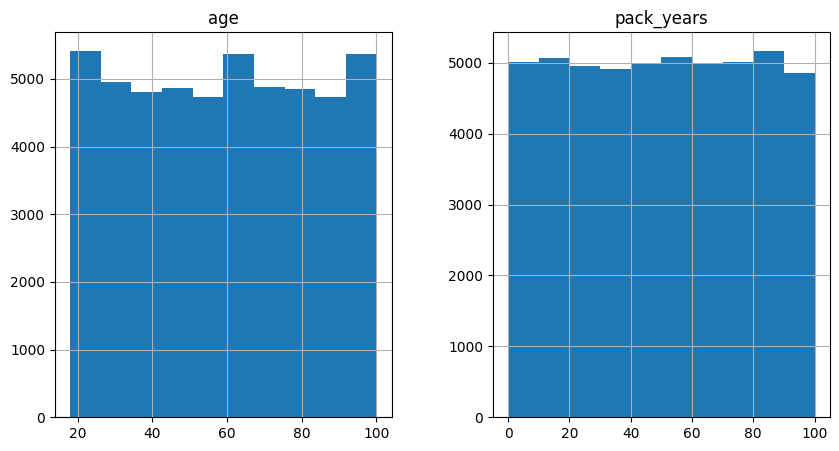

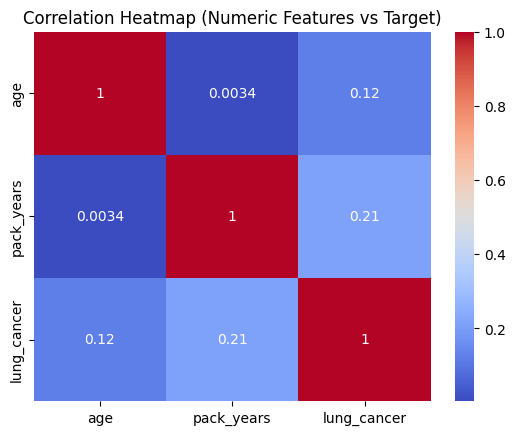

In [ ]:
# Drop patient_id (not useful)
if "patient_id" in df.columns:
    df = df.drop(columns=["patient_id"])

# Encode Yes/No → 1/0
binary_map = {"Yes": 1, "No": 0}
for col in ["asbestos_exposure", "secondhand_smoke_exposure",
            "copd_diagnosis", "family_history", "lung_cancer"]:
    df[col] = df[col].map(binary_map)

# Preview dataset
print(df.head())

# Missing values
print("\nMissing values:\n", df.isnull().sum())

# Class balance
sns.countplot(x="lung_cancer", data=df)
plt.title("Class Distribution (Target)")
plt.show()

# Numeric distributions
num_cols = ["age", "pack_years"]
df[num_cols].hist(figsize=(10,5))
plt.show()

# Correlation heatmap (numeric + encoded binary target)
sns.heatmap(df[num_cols + ["lung_cancer"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features vs Target)")
plt.show()

**3. Preprocessing**

In [ ]:
def preprocess_df(df, target="lung_cancer", enc_method='label', scaler='standard', smote=True):
    df_proc = df.copy()

    # Numeric & categorical
    num_cols = ["age", "pack_years"]
    cat_cols = [c for c in df_proc.columns if c not in num_cols + [target]]

    # Impute missing values
    num_imputer = SimpleImputer(strategy="median")
    cat_imputer = SimpleImputer(strategy="most_frequent")
    df_proc[num_cols] = num_imputer.fit_transform(df_proc[num_cols])
    df_proc[cat_cols] = cat_imputer.fit_transform(df_proc[cat_cols])

    # Encode categoricals
    if enc_method == 'label':
        for col in cat_cols:
            le = LabelEncoder()
            df_proc[col] = le.fit_transform(df_proc[col].astype(str))
    else:
        df_proc = pd.get_dummies(df_proc, columns=cat_cols, drop_first=True)

    # Scale numerics
    if scaler == 'standard':
        s = StandardScaler()
    else:
        s = MinMaxScaler()
    df_proc[num_cols] = s.fit_transform(df_proc[num_cols])

    # Split train/test
    X = df_proc.drop(columns=[target])
    y = df_proc[target].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

    # Handle imbalance
    if smote:
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_df(df)
print(X_train.shape, X_test.shape)

(54982, 9) (10000, 9)


**4. Machine Learning Models**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Optimized models dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    "SVM (Linear)": SVC(kernel="linear", probability=True, max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5, algorithm="ball_tree", n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_jobs=-1, random_state=42)
}

# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    else:
        y_prob = None
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

# Training and evaluation
ml_results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    ml_results[name] = evaluate_model(model, X_test, y_test)

# Convert results to DataFrame
results_df = pd.DataFrame(ml_results).T

# Convert decimal → percentage format
results_df = results_df.applymap(lambda x: f"{x*100:.2f}%" if pd.notnull(x) else "N/A")

# Display final results table
print("\nMachine Learning Model Performance (in %):")
display(results_df)

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training SVM (Linear)...
Training KNN...
Training XGBoost...

Machine Learning Model Performance (in %):


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,67.03%,81.75%,66.99%,73.63%,74.01%
Decision Tree,62.74%,75.67%,67.48%,71.34%,59.90%
Random Forest,66.68%,78.27%,71.32%,74.63%,70.83%
SVM (Linear),47.96%,66.18%,49.67%,56.75%,47.79%
KNN,63.75%,78.49%,65.10%,71.17%,67.84%
XGBoost,70.65%,81.12%,74.68%,77.77%,75.75%


from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('accuracy').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('precision').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('recall').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('f1').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['precision'].value_counts()
    for x_label, grp in results_df.groupby('accuracy')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('accuracy')
_ = plt.ylabel('precision')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['recall'].value_counts()
    for x_label, grp in results_df.groupby('precision')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('precision')
_ = plt.ylabel('recall')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['f1'].value_counts()
    for x_label, grp in results_df.groupby('recall')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('recall')
_ = plt.ylabel('f1')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['roc_auc'].value_counts()
    for x_label, grp in results_df.groupby('f1')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('f1')
_ = plt.ylabel('roc_auc')

from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('accuracy').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('precision').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('recall').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['accuracy'].value_counts()
    for x_label, grp in _df_4.groupby('index')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('index')
_ = plt.ylabel('accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['precision'].value_counts()
    for x_label, grp in _df_5.groupby('accuracy')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('accuracy')
_ = plt.ylabel('precision')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['recall'].value_counts()
    for x_label, grp in _df_6.groupby('precision')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('precision')
_ = plt.ylabel('recall')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['f1'].value_counts()
    for x_label, grp in _df_7.groupby('recall')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('recall')
_ = plt.ylabel('f1')

**5. Deep Learning Models (Optimized)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping

# Convert to numpy
Xtr, Xte = X_train.values, X_test.values
ytr, yte = y_train.values, y_test.values

# Early stopping to prevent long training
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)

# ----------------
# 5.1 MLP
# ----------------
mlp = Sequential([
    Dense(64, activation="relu", input_shape=(Xtr.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])
mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
mlp.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=20, batch_size=32, callbacks=[es], verbose=1)

# ----------------
# 5.2 CNN
# ----------------
cnn = Sequential([
    Input(shape=(Xtr.shape[1],1)),
    Conv1D(32, 3, activation="relu"),
    Conv1D(64, 3, activation="relu"),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn.fit(Xtr.reshape(-1,Xtr.shape[1],1), ytr, validation_data=(Xte.reshape(-1,Xte.shape[1],1), yte),
        epochs=20, batch_size=32, callbacks=[es], verbose=1)

# ----------------
# 5.3 LSTM
# ----------------
lstm = Sequential([
    Input(shape=(Xtr.shape[1],1)),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])
lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm.fit(Xtr.reshape(-1,Xtr.shape[1],1), ytr, validation_data=(Xte.reshape(-1,Xte.shape[1],1), yte),
         epochs=20, batch_size=32, callbacks=[es], verbose=1)

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6509 - loss: 0.6070 - val_accuracy: 0.6934 - val_loss: 0.5594
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6852 - loss: 0.5764 - val_accuracy: 0.6696 - val_loss: 0.5877
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6887 - loss: 0.5726 - val_accuracy: 0.6833 - val_loss: 0.5658
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6900 - loss: 0.5695 - val_accuracy: 0.6768 - val_loss: 0.5715
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6699 - loss: 0.5964 - val_accuracy: 0.7052 - val_loss: 0.5463
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6849 - loss: 0.5739 - val_accuracy: 0.6829 - val_loss: 0.5715
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6839 - loss: 0.5733 - val_accuracy: 0.6801 - val_loss: 0.5652
Epoch 4

**6. Evaluate Deep Learning Models**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def eval_dl(model, X, y, name, reshape=False):
    if reshape:
        X = X.reshape(-1, X.shape[1], 1)
    y_prob = model.predict(X).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1": f1_score(y, y_pred),
        "ROC-AUC": roc_auc_score(y, y_prob)
    }

# Collect DL results
dl_results = []
dl_results.append(eval_dl(mlp, Xte, yte, "MLP"))
dl_results.append(eval_dl(cnn, Xte, yte, "CNN", reshape=True))
dl_results.append(eval_dl(lstm, Xte, yte, "LSTM", reshape=True))

dl_df = pd.DataFrame(dl_results)

# Convert to % format
dl_df = dl_df.set_index("Model")
dl_df = dl_df.applymap(lambda x: f"{x*100:.2f}%" if pd.notnull(x) else "N/A")

print("\nDeep Learning Models Performance (in %):")
display(dl_df)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Deep Learning Models Performance (in %):


,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
MLP,69.34%,82.42%,70.41%,75.94%,75.96%
CNN,70.52%,81.35%,74.09%,77.55%,76.23%
LSTM,69.85%,82.67%,71.02%,76.40%,76.80%


**7. Explainable AI (XAI)**

In [ ]:
!pip install lime

In [ ]:
!pip install pdpbox

Running SHAP on 1000 samples...


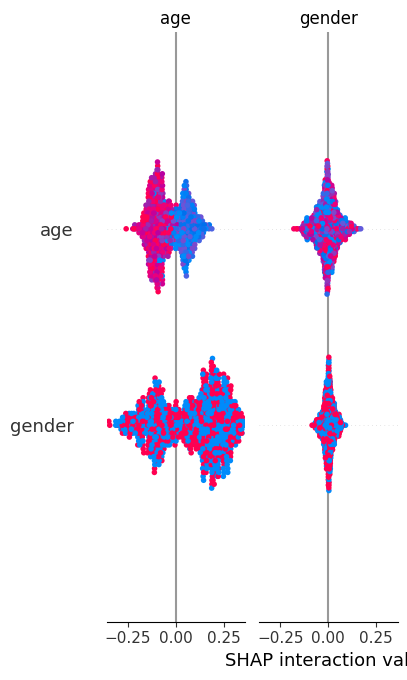

Running LIME on 1 instance...


Generating PDP for 'age'...


AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_isolate'

In [ ]:
import shap
import lime.lime_tabular
from pdpbox import pdp

# -----------------------------
# SHAP (Random Forest) - Sample
# -----------------------------
print("Running SHAP on 1000 samples...")
sample_X = X_test.sample(1000, random_state=42)   # sample for speed
explainer = shap.TreeExplainer(models["Random Forest"])
shap_values = explainer.shap_values(sample_X)
shap.summary_plot(shap_values, sample_X, feature_names=X_test.columns)

# -----------------------------
# LIME (Local Explanation)
# -----------------------------
print("Running LIME on 1 instance...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train.sample(2000, random_state=42)),  # smaller subset
    feature_names=X_train.columns,
    class_names=["No Cancer","Cancer"],
    mode="classification"
)

# Explain the first test instance
exp = lime_explainer.explain_instance(
    X_test.iloc[0], models["Random Forest"].predict_proba, num_features=6
)
exp.show_in_notebook()

# -----------------------------
# PDP (Partial Dependence Plot)
# -----------------------------
print("Generating PDP for 'age'...")
pdp_age = pdp.pdp_isolate(
    model=models["Random Forest"],
    dataset=X_test.sample(2000, random_state=42),  # subset for speed
    model_features=X_test.columns,
    feature="age",
    num_grid_points=20  # fewer grid points for faster plotting
)
pdp.pdp_plot(pdp_age, "age")
plt.show()

**8. Comparative Analysis (ML vs DL Table)**

In [ ]:
# Combine ML + DL tables
final_results = pd.concat([results_df, dl_df])
print("\nFinal Comparative Performance (ML + DL in %):")
display(final_results)


Final Comparative Performance (ML + DL in %):


,accuracy,precision,recall,f1,roc_auc,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,67.03%,81.75%,66.99%,73.63%,74.01%,NaN,NaN,NaN,NaN,NaN
Decision Tree,62.74%,75.67%,67.48%,71.34%,59.90%,NaN,NaN,NaN,NaN,NaN
Random Forest,66.68%,78.27%,71.32%,74.63%,70.83%,NaN,NaN,NaN,NaN,NaN
SVM (Linear),47.96%,66.18%,49.67%,56.75%,47.79%,NaN,NaN,NaN,NaN,NaN
KNN,63.75%,78.49%,65.10%,71.17%,67.84%,NaN,NaN,NaN,NaN,NaN
XGBoost,70.65%,81.12%,74.68%,77.77%,75.75%,NaN,NaN,NaN,NaN,NaN
MLP,NaN,NaN,NaN,NaN,NaN,69.34%,82.42%,70.41%,75.94%,75.96%
CNN,NaN,NaN,NaN,NaN,NaN,70.52%,81.35%,74.09%,77.55%,76.23%
LSTM,NaN,NaN,NaN,NaN,NaN,69.85%,82.67%,71.02%,76.40%,76.80%
